## Домашняя работа 3 TensorFlov

### Задание:

Постройте нейронную сеть (берем несложную полносвязную сеть, меняем число слоев, число нейронов, типы активации, тип оптимизатора) на датасете from sklearn.datasets import load_boston.

Постройте 10-15 вариантов разных нейронных сетей и сведите результаты их работы в таблицу. Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

# Загрузка данных

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import mean_squared_error as sklearn_mean_squared_error 

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.datasets import load_boston
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy, mean_squared_error 
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError
from keras.callbacks import EarlyStopping

In [2]:
boston_data = load_boston()
df = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
df['target'] = pd.Series(boston_data.target)
print(df.shape)
df.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
X = df.drop(['target'], axis=1)
y = df['target']

In [4]:
MinMaxSc = MinMaxScaler()
X_scaled = MinMaxSc.fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state=1)

In [6]:
df = pd.DataFrame(columns=['No. layers', 'No. neurons', 'act_func', 'opt', 'train', 'test'])
i = 0

### 3 слоя, 256 нейронов

In [7]:
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=100,
                           verbose=1,
                           mode='auto',
                           baseline=None,
                           restore_best_weights=False)

input_layer = Input(shape=(X_train.shape[1],))
dense_layer_1 = Dense(256, activation='relu')(input_layer)
dense_layer_2 = Dense(256, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(256, activation='relu')(dense_layer_2)
output = Dense(1)(dense_layer_3)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

history = model.fit(X_train, y_train, 
                    batch_size=5, 
                    epochs=10, 
                    verbose=0,
                    callbacks=[early_stop],
                    validation_data=(X_test, y_test),
                   )

y_pred_train = model.predict(X_train)
print(np.sqrt(sklearn_mean_squared_error(y_train, y_pred_train)))

y_pred_test = model.predict(X_test)
print(np.sqrt(sklearn_mean_squared_error(y_test, y_pred_test)))

r2_train = round(r2_score(y_train, y_pred_train), 4)
r2_test = round(r2_score(y_test, y_pred_test), 4)

3.640970044497018
3.226204438424971


In [8]:
n_neurons = [int(i) for i in np.geomspace(51, 1000, num=10, axis=0).tolist()]
n_neurons

[50, 70, 98, 137, 191, 266, 370, 516, 718, 1000]

### batch size

### 3 слоя, 50-100 нейронов

In [9]:
df = pd.DataFrame(columns=['No. layers', 'No. neurons', 'act_func', 'opt', 'train', 'test'])
i = 0

In [10]:
for n_neuron in tqdm(n_neurons):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(n_neuron, activation='relu')(input_layer)
    output = Dense(1)(dense_layer_1)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history = model.fit(X_train, y_train, 
                        batch_size=10, 
                        epochs=10, 
                        verbose=0,
                        validation_data=(X_test, y_test),
                       )

    y_pred_train = model.predict(X_train)

    y_pred_test = model.predict(X_test)
    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred_test), 4)

    df.loc[i] = [3, n_neuron, 'ReLu', 'Adam', r2_train, r2_test]
    i += 1
df

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.05s/it]


,No. layers,No. neurons,act_func,opt,train,test
0,3,50,ReLu,Adam,-0.2802,-0.2637
1,3,70,ReLu,Adam,-0.2101,-0.1822
2,3,98,ReLu,Adam,-0.0381,-0.0325
3,3,137,ReLu,Adam,0.1445,0.1385
4,3,191,ReLu,Adam,0.2231,0.2051
5,3,266,ReLu,Adam,0.3082,0.3037
6,3,370,ReLu,Adam,0.3707,0.3753
7,3,516,ReLu,Adam,0.4291,0.4523
8,3,718,ReLu,Adam,0.4561,0.4984
9,3,1000,ReLu,Adam,0.4839,0.5293


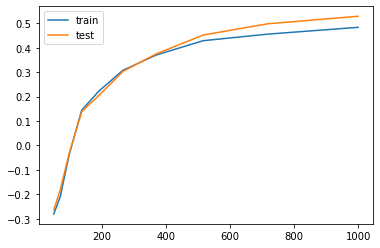

In [11]:
plt.plot(df['No. neurons'], df['train'], label='train')
plt.plot(df['No. neurons'], df['test'], label='test')
plt.legend();

### 3 слоя, 50-100 нейронов

In [12]:
df = pd.DataFrame(columns=['No. layers', 'No. neurons', 'act_func', 'opt', 'train', 'test'])
i = 0

In [13]:
for n_neuron in tqdm(n_neurons):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(n_neuron, activation='relu')(input_layer)
    output = Dense(1)(dense_layer_1)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history = model.fit(X_train, y_train, 
                        batch_size=5, 
                        epochs=10, 
                        verbose=0,
                        validation_data=(X_test, y_test),
                       )

    y_pred_train = model.predict(X_train)

    y_pred_test = model.predict(X_test)

    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred_test), 4)

    df.loc[i] = [3, n_neuron, 'ReLu', 'Adam', r2_train, r2_test]
    i += 1
df

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.27s/it]


,No. layers,No. neurons,act_func,opt,train,test
0,3,50,ReLu,Adam,0.2381,0.2343
1,3,70,ReLu,Adam,0.2934,0.2919
2,3,98,ReLu,Adam,0.3826,0.3921
3,3,137,ReLu,Adam,0.4264,0.4542
4,3,191,ReLu,Adam,0.4639,0.4845
5,3,266,ReLu,Adam,0.5098,0.5535
6,3,370,ReLu,Adam,0.5534,0.5983
7,3,516,ReLu,Adam,0.5944,0.6420
8,3,718,ReLu,Adam,0.6001,0.6460
9,3,1000,ReLu,Adam,0.6579,0.7287


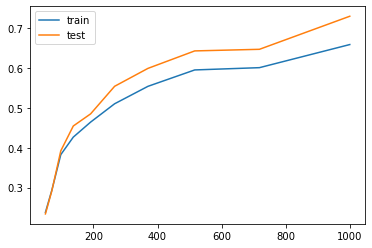

In [14]:
plt.plot(df['No. neurons'], df['train'], label='train')
plt.plot(df['No. neurons'], df['test'], label='test')
plt.legend();

### 3 слоя, 50-100 нейронов

In [15]:
df = pd.DataFrame(columns=['No. layers', 'No. neurons', 'act_func', 'opt', 'train', 'test'])
i = 0

In [16]:
for n_neuron in tqdm(n_neurons):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(n_neuron, activation='relu')(input_layer)
    output = Dense(1)(dense_layer_1)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history = model.fit(X_train, y_train, 
                        batch_size=1, 
                        epochs=10, 
                        verbose=0,
                        validation_data=(X_test, y_test),
                       )

    y_pred_train = model.predict(X_train)

    y_pred_test = model.predict(X_test)

    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred_test), 4)

    df.loc[i] = [3, n_neuron, 'ReLu', 'Adam', r2_train, r2_test]
    i += 1
df

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.70s/it]


,No. layers,No. neurons,act_func,opt,train,test
0,3,50,ReLu,Adam,0.5659,0.6164
1,3,70,ReLu,Adam,0.6071,0.6623
2,3,98,ReLu,Adam,0.6290,0.7005
3,3,137,ReLu,Adam,0.6743,0.7474
4,3,191,ReLu,Adam,0.6977,0.7810
5,3,266,ReLu,Adam,0.7014,0.7876
6,3,370,ReLu,Adam,0.7007,0.7873
7,3,516,ReLu,Adam,0.7297,0.8166
8,3,718,ReLu,Adam,0.7348,0.8219
9,3,1000,ReLu,Adam,0.7374,0.8206


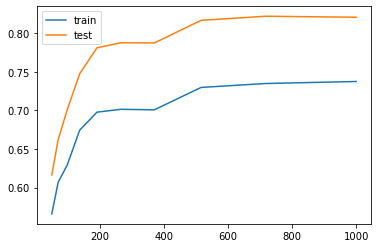

In [17]:
plt.plot(df['No. neurons'], df['train'], label='train')
plt.plot(df['No. neurons'], df['test'], label='test')
plt.legend();

## Подытог:

Уменьшение batch ускоряет обучение модели.

## Количество слоёв

### 3 слоя, 50-100 нейронов

In [18]:
df = pd.DataFrame(columns=['No. layers', 'No. neurons', 'act_func', 'opt', 'train', 'test'])
i = 0

In [19]:
for n_neuron in tqdm(n_neurons):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(n_neuron, activation='relu')(input_layer)
    output = Dense(1)(dense_layer_1)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history = model.fit(X_train, y_train, 
                        batch_size=1, 
                        epochs=10, 
                        verbose=0,
                        validation_data=(X_test, y_test),
                       )

    y_pred_train = model.predict(X_train)

    y_pred_test = model.predict(X_test)

    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred_test), 4)

    df.loc[i] = [3, n_neuron, 'ReLu', 'Adam', r2_train, r2_test]
    i += 1
df

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.75s/it]


,No. layers,No. neurons,act_func,opt,train,test
0,3,50,ReLu,Adam,0.5479,0.5923
1,3,70,ReLu,Adam,0.5728,0.6542
2,3,98,ReLu,Adam,0.6554,0.7254
3,3,137,ReLu,Adam,0.6410,0.7232
4,3,191,ReLu,Adam,0.6913,0.7756
5,3,266,ReLu,Adam,0.7020,0.7910
6,3,370,ReLu,Adam,0.7074,0.7920
7,3,516,ReLu,Adam,0.7114,0.8013
8,3,718,ReLu,Adam,0.7117,0.8016
9,3,1000,ReLu,Adam,0.7255,0.8186


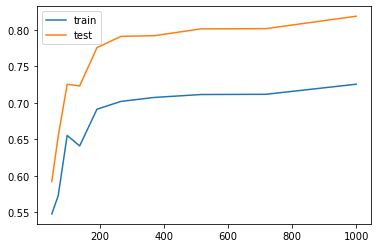

In [20]:
plt.plot(df['No. neurons'], df['train'], label='train')
plt.plot(df['No. neurons'], df['test'], label='test')
plt.legend();

### 4 слоя, 50-100 нейронов

In [21]:
df = pd.DataFrame(columns=['No. layers', 'No. neurons', 'act_func', 'opt', 'train', 'test'])
i = 0

In [22]:
for n_neuron in tqdm(n_neurons):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(n_neuron, activation='relu')(input_layer)
    dense_layer_2 = Dense(n_neuron, activation='relu')(dense_layer_1)
    output = Dense(1)(dense_layer_2)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history = model.fit(X_train, y_train, 
                        batch_size=1, 
                        epochs=10, 
                        verbose=0,
                        validation_data=(X_test, y_test),
                       )

    y_pred_train = model.predict(X_train)

    y_pred_test = model.predict(X_test)

    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred_test), 4)

    df.loc[i] = [4, n_neuron, 'ReLu', 'Adam', r2_train, r2_test]
    i += 1
df

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.75s/it]


,No. layers,No. neurons,act_func,opt,train,test
0,4,50,ReLu,Adam,0.7474,0.8247
1,4,70,ReLu,Adam,0.5825,0.6787
2,4,98,ReLu,Adam,0.7801,0.8609
3,4,137,ReLu,Adam,0.7881,0.8605
4,4,191,ReLu,Adam,0.8349,0.8963
5,4,266,ReLu,Adam,0.7226,0.8027
6,4,370,ReLu,Adam,0.8095,0.8710
7,4,516,ReLu,Adam,0.8435,0.8932
8,4,718,ReLu,Adam,0.8388,0.8968
9,4,1000,ReLu,Adam,0.8532,0.9067


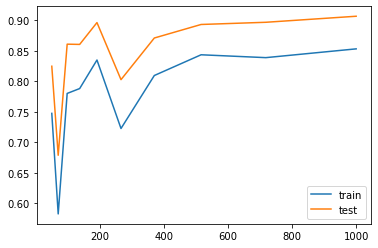

In [23]:
plt.plot(df['No. neurons'], df['train'], label='train')
plt.plot(df['No. neurons'], df['test'], label='test')
plt.legend();

### 5 слоёв, 50-100 нейронов

In [24]:
df = pd.DataFrame(columns=['No. layers', 'No. neurons', 'act_func', 'opt', 'train', 'test'])
i = 0

In [25]:
for n_neuron in tqdm(n_neurons):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(n_neuron, activation='relu')(input_layer)
    dense_layer_2 = Dense(n_neuron, activation='relu')(dense_layer_1)
    dense_layer_3 = Dense(n_neuron, activation='relu')(dense_layer_2)
    output = Dense(1)(dense_layer_3)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history = model.fit(X_train, y_train, 
                        batch_size=1, 
                        epochs=10, 
                        verbose=0,
                        validation_data=(X_test, y_test),
                       )

    y_pred_train = model.predict(X_train)

    y_pred_test = model.predict(X_test)

    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred_test), 4)

    df.loc[i] = [5, n_neuron, 'ReLu', 'Adam', r2_train, r2_test]
    i += 1
df

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:08<00:00,  6.82s/it]


,No. layers,No. neurons,act_func,opt,train,test
0,5,50,ReLu,Adam,0.7874,0.8623
1,5,70,ReLu,Adam,0.7854,0.8626
2,5,98,ReLu,Adam,0.7910,0.8748
3,5,137,ReLu,Adam,0.8337,0.8819
4,5,191,ReLu,Adam,0.8073,0.8677
5,5,266,ReLu,Adam,0.8408,0.8843
6,5,370,ReLu,Adam,0.8034,0.8577
7,5,516,ReLu,Adam,0.8205,0.8757
8,5,718,ReLu,Adam,0.8561,0.8971
9,5,1000,ReLu,Adam,0.7800,0.8132


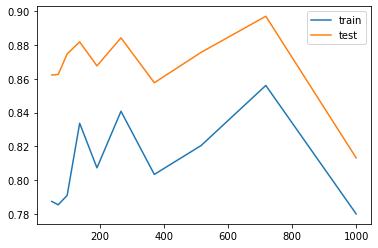

In [26]:
plt.plot(df['No. neurons'], df['train'], label='train')
plt.plot(df['No. neurons'], df['test'], label='test')
plt.legend();

### 6 слоёв, 50-100 нейронов

In [27]:
df = pd.DataFrame(columns=['No. layers', 'No. neurons', 'act_func', 'opt', 'train', 'test'])
i = 0

In [28]:
for n_neuron in tqdm(n_neurons, leave=False):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(n_neuron, activation='relu')(input_layer)
    dense_layer_2 = Dense(n_neuron, activation='relu')(dense_layer_1)
    dense_layer_3 = Dense(n_neuron, activation='relu')(dense_layer_2)
    dense_layer_4 = Dense(n_neuron, activation='relu')(dense_layer_3)
    output = Dense(1)(dense_layer_4)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history = model.fit(X_train, y_train, 
                        batch_size=1, 
                        epochs=10, 
                        verbose=0,
                        validation_data=(X_test, y_test),
                       )

    y_pred_train = model.predict(X_train)

    y_pred_test = model.predict(X_test)

    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred_test), 4)

    df.loc[i] = [6, n_neuron, 'ReLu', 'Adam', r2_train, r2_test]
    i += 1
df

,No. layers,No. neurons,act_func,opt,train,test
0,6,50,ReLu,Adam,0.8026,0.8708
1,6,70,ReLu,Adam,0.8211,0.8815
2,6,98,ReLu,Adam,0.7946,0.8510
3,6,137,ReLu,Adam,0.8047,0.8402
4,6,191,ReLu,Adam,0.8628,0.8931
5,6,266,ReLu,Adam,0.7911,0.8316
6,6,370,ReLu,Adam,0.8679,0.8938
7,6,516,ReLu,Adam,0.8678,0.9084
8,6,718,ReLu,Adam,0.8231,0.8764
9,6,1000,ReLu,Adam,0.8164,0.8601


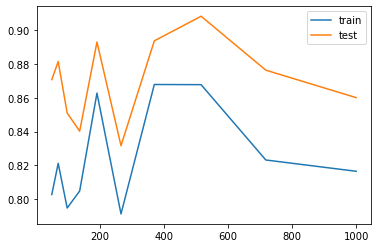

In [29]:
plt.plot(df['No. neurons'], df['train'], label='train')
plt.plot(df['No. neurons'], df['test'], label='test')
plt.legend();

### 7 слоёв, 50-100 нейронов

In [30]:
df = pd.DataFrame(columns=['No. layers', 'No. neurons', 'act_func', 'opt', 'train', 'test'])
i = 0

In [31]:
for n_neuron in tqdm(n_neurons):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(n_neuron, activation='relu')(input_layer)
    dense_layer_2 = Dense(n_neuron, activation='relu')(dense_layer_1)
    dense_layer_3 = Dense(n_neuron, activation='relu')(dense_layer_2)
    dense_layer_4 = Dense(n_neuron, activation='relu')(dense_layer_3)
    dense_layer_5 = Dense(n_neuron, activation='relu')(dense_layer_4)
    output = Dense(1)(dense_layer_5)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history = model.fit(X_train, y_train, 
                        batch_size=1, 
                        epochs=10, 
                        verbose=0,
                        validation_data=(X_test, y_test),
                       )

    y_pred_train = model.predict(X_train)

    y_pred_test = model.predict(X_test)

    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred_test), 4)

    df.loc[i] = [7, n_neuron, 'ReLu', 'Adam', r2_train, r2_test]
    i += 1
df

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:02<00:00, 12.26s/it]


,No. layers,No. neurons,act_func,opt,train,test
0,7,50,ReLu,Adam,0.8334,0.9037
1,7,70,ReLu,Adam,0.8508,0.8969
2,7,98,ReLu,Adam,0.6895,0.7212
3,7,137,ReLu,Adam,0.7155,0.7817
4,7,191,ReLu,Adam,0.8029,0.8574
5,7,266,ReLu,Adam,0.8345,0.8423
6,7,370,ReLu,Adam,0.7682,0.8201
7,7,516,ReLu,Adam,0.6826,0.6804
8,7,718,ReLu,Adam,0.2940,0.3277
9,7,1000,ReLu,Adam,0.8488,0.8878


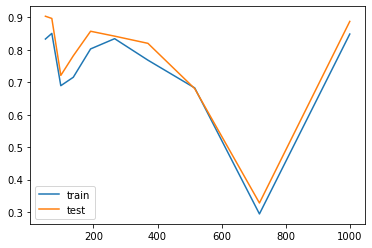

In [32]:
plt.plot(df['No. neurons'], df['train'], label='train')
plt.plot(df['No. neurons'], df['test'], label='test')
plt.legend();

### 9 слоёв, 50-100 нейронов, ReLU, Adam

In [33]:
df = pd.DataFrame(columns=['No. layers', 'No. neurons', 'act_func', 'opt', 'train', 'test'])
i = 0

In [34]:
for n_neuron in tqdm(n_neurons):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(n_neuron, activation='relu')(input_layer)
    dense_layer_2 = Dense(n_neuron, activation='relu')(dense_layer_1)
    dense_layer_3 = Dense(n_neuron, activation='relu')(dense_layer_2)
    dense_layer_4 = Dense(n_neuron, activation='relu')(dense_layer_3)
    dense_layer_5 = Dense(n_neuron, activation='relu')(dense_layer_4)
    dense_layer_6 = Dense(n_neuron, activation='relu')(dense_layer_5)
    dense_layer_7 = Dense(n_neuron, activation='relu')(dense_layer_6)
    output = Dense(1)(dense_layer_7)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history = model.fit(X_train, y_train, 
                        batch_size=1, 
                        epochs=10, 
                        verbose=0,
                        validation_data=(X_test, y_test),
                       )

    y_pred_train = model.predict(X_train)

    y_pred_test = model.predict(X_test)

    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred_test), 4)

    df.loc[i] = [9, n_neuron, 'ReLu', 'Adam', r2_train, r2_test]
    i += 1
df

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:35<00:00, 15.59s/it]


,No. layers,No. neurons,act_func,opt,train,test
0,9,50,ReLu,Adam,0.8277,0.8867
1,9,70,ReLu,Adam,0.1943,0.2699
2,9,98,ReLu,Adam,0.7532,0.8227
3,9,137,ReLu,Adam,0.7726,0.8280
4,9,191,ReLu,Adam,0.7516,0.7820
5,9,266,ReLu,Adam,0.6934,0.7693
6,9,370,ReLu,Adam,0.5622,0.6557
7,9,516,ReLu,Adam,0.7526,0.8085
8,9,718,ReLu,Adam,0.7515,0.8068
9,9,1000,ReLu,Adam,0.7744,0.8282


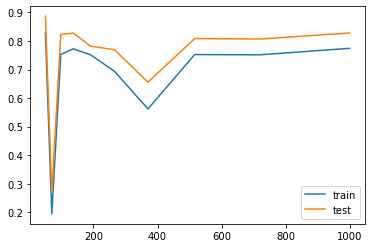

In [35]:
plt.plot(df['No. neurons'], df['train'], label='train')
plt.plot(df['No. neurons'], df['test'], label='test')
plt.legend();

## Подитог:

Четыре - самое оптимальное число слоёв. При трёх - недообучение. Пять и выше - метрики начинают снижаться и обучение становится нестабильным.

Переучим модель с четырьмя слоями и batch - 1 и оптимальным количеством нейронов - 400.

# Финальная модель

4 слоя, батч = 1

In [42]:
df = pd.DataFrame(columns=['No. layers', 'epoches', 'act_func', 'opt', 'train', 'test'])
i = 0

In [43]:
for epoch in tqdm([10, 50, 100, 200, 500]):
    input_layer = Input(shape=(X_train.shape[1],))
    dense_layer_1 = Dense(400, activation='relu')(input_layer)
    dense_layer_2 = Dense(400, activation='relu')(dense_layer_1)
    output = Dense(1)(dense_layer_2)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

    history = model.fit(X_train, y_train, 
                        batch_size=1, 
                        epochs=epoch, 
                        verbose=0,
                        validation_data=(X_test, y_test),
                       )

    y_pred_train = model.predict(X_train)

    y_pred_test = model.predict(X_test)

    r2_train = round(r2_score(y_train, y_pred_train), 4)
    r2_test = round(r2_score(y_test, y_pred_test), 4)

    df.loc[i] = [4, epoch, 'ReLu', 'Adam', r2_train, r2_test]
    i += 1
df

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:23<00:00, 52.75s/it]


,No. layers,epoches,act_func,opt,train,test
0,4,10,ReLu,Adam,0.7998,0.8609
1,4,50,ReLu,Adam,0.9236,0.9222
2,4,100,ReLu,Adam,0.9529,0.9005
3,4,200,ReLu,Adam,0.9719,0.9217
4,4,500,ReLu,Adam,0.9828,0.9011


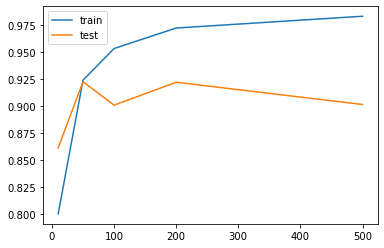

In [44]:
plt.plot(df['epoches'], df['train'], label='train')
plt.plot(df['epoches'], df['test'], label='test')
plt.legend();

# Вывод:

Количество эпох должно быть небольшим. При росте эпох увеличивается переобучяемость модели.

Лучшая модель: 4 слоя, 1 batch и 50 эпох